In [92]:
import json
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.signal import find_peaks
from scipy.stats import linregress

In [93]:
with open("Bangs_44nm_GreenFS_6.txt", "r") as f:
    lines = f.readlines()

In [94]:
header_metadata = {}
i = 0
while not lines[i].startswith("***end header***"):
    line = lines[i].strip()
    if ':' in line:
        key, value = line.split(":", 1)
        header_metadata[key.strip()] = value.strip()
    i+=1
i+=1

with open("metadata_Bangs_44nm_GreenFS_6.json", "w") as json_file:
    json.dump(header_metadata, json_file, indent=4)

In [95]:
photon_counts = []
for line in lines[i:]:
    line = line.strip()
    if line and not line.startswith("Ch"):
        photon_counts.append(int(line))
mt_clock_ps = float(header_metadata["MT Clock"].split()[0])
toa_microsec = np.array(photon_counts) * mt_clock_ps * 1e-6  # convert to microseconds

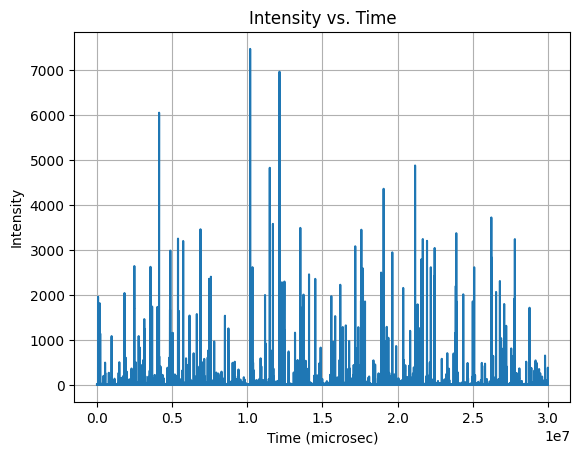

In [96]:
bin_width = 600  # microseconds
max_time = np.max(toa_microsec)
bins = np.arange(0, max_time + bin_width, bin_width)
hist, edges = np.histogram(toa_microsec, bins=bins)
bin_centers = (edges[:-1] + edges[1:]) / 2
plt.figure()
plt.plot(bin_centers, hist, drawstyle='steps-mid')
plt.xlabel("Time (microsec)")
plt.ylabel("Intensity")
plt.title("Intensity vs. Time")
plt.grid(True)
plt.show()

In [97]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=bin_centers,
    y=hist,
    mode='lines',
    line_shape='hv',
    name='Intensity'
))

fig.update_layout(
    title='Intensity vs. Time',
    xaxis_title='Time (microsec)',
    yaxis_title='Intensity',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

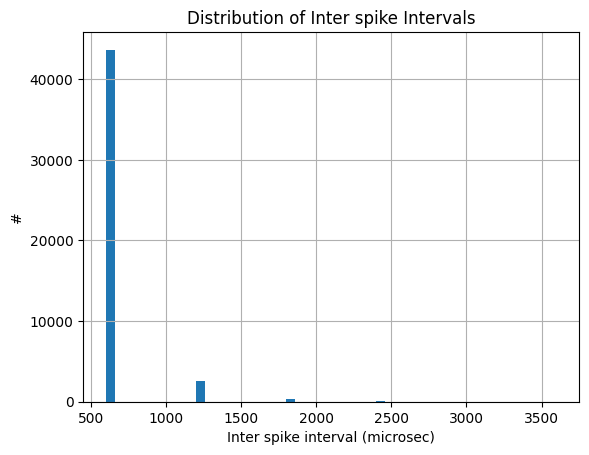

In [98]:
#verify that there multiple bursts aren't being captured under the same spike. Most should be greater than 500 to resolve bursts
nonzero_bins = bin_centers[hist > 0]
inter_spike_intervals = np.diff(nonzero_bins)  # delta t between spikes
plt.figure()
plt.hist(inter_spike_intervals, bins=50)
plt.xlabel("Inter spike interval (microsec)")
plt.ylabel("#")
plt.title("Distribution of Inter spike Intervals")
plt.grid(True)
plt.show()


In [99]:
#verify that all spikes are isolated
isolated_spikes = np.sum(inter_spike_intervals > 500)
total_spikes = len(inter_spike_intervals)
isolation_ratio = isolated_spikes / total_spikes
f"{isolation_ratio:.4f}"

'1.0000'

In [100]:
np.save("toa_microsec.npy", toa_microsec)
toa_microsec

array([2.58972611e+02, 3.42584673e+02, 4.50429375e+02, ...,
       3.00019851e+07, 3.00019963e+07, 3.00019994e+07], shape=(760652,))

In [101]:
def detect_peaks(toa_microsec, bin_width=600, plot = False):
    noise_floor = np.median(hist)
    noise_region = hist[hist <= noise_floor + 3 * np.std(hist)]  # conservative subset
    noise_std = np.std(noise_region)
    threshold = noise_floor + 5 * noise_std 
    
    peaks, properties = find_peaks(hist, height=threshold, distance=3)

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(bin_centers, hist, drawstyle='steps-mid', alpha=0.7)
        plt.plot(bin_centers[peaks], hist[peaks], 'rx', label='Detected Peaks')
        plt.axhline(threshold, color='gray', linestyle='--', label='Threshold')
        plt.xlabel('Time (microsec)')
        plt.ylabel('Intensity')
        plt.title('Intensity vs Time with Detected Peaks')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=bin_centers, y=hist, mode='lines', name='Intensity', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=bin_centers[peaks], y=hist[peaks],
                                        mode='markers', marker=dict(color='red', size=8),
                                        name='Detected Peaks'))
        fig.add_trace(go.Scatter(x=[bin_centers[0], bin_centers[-1]],
                                        y=[threshold, threshold],
                                        mode='lines', name=f'Threshold ≈ {threshold:.1f}',
                                        line=dict(color='gray', dash='dash')))
        fig.update_layout(title='Intensity vs Time with Detected Peaks',
                                xaxis_title='Time (microsec)', yaxis_title='Intensity',
                                showlegend=True)
        fig.show()

    return bin_centers[peaks], hist[peaks]

In [102]:
toa_microsec = np.load("toa_microsec.npy")
peak_times, peak_heights = detect_peaks(toa_microsec, bin_width=600)

In [103]:
#DISCRETE VALUES, NO BINNING
unique, counts = np.unique(peak_heights, return_counts=True)
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.log10(unique),
    y=np.log10(counts),
    mode='markers',
    name='Intensity Distribution'
))
fig.update_layout(
    title='Distribution of Intensities',
    xaxis_title='log10(Peak Intensity)',
    yaxis_title='log10(Count)',
    showlegend=False
)
fig.show()

In [104]:
#LOG SPACED BINNNING -  NO KDE
min_intensity = np.min(peak_heights)
max_intensity = np.max(peak_heights)
bins = np.logspace(np.log10(min_intensity), np.log10(max_intensity), num=50)


counts, edges = np.histogram(peak_heights, bins=bins)


bin_centers = (edges[:-1] + edges[1:]) / 2
nonzero = counts > 0

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.log10(bin_centers[nonzero]),
    y=np.log10(counts[nonzero]),
    mode='markers',
    name='Intensity Distribution'
))
fig.update_layout(
    title='Distribution of Intensities',
    xaxis_title='log10(Intensity)',
    yaxis_title='log10(Count)',
    showlegend=False
)
fig.show()

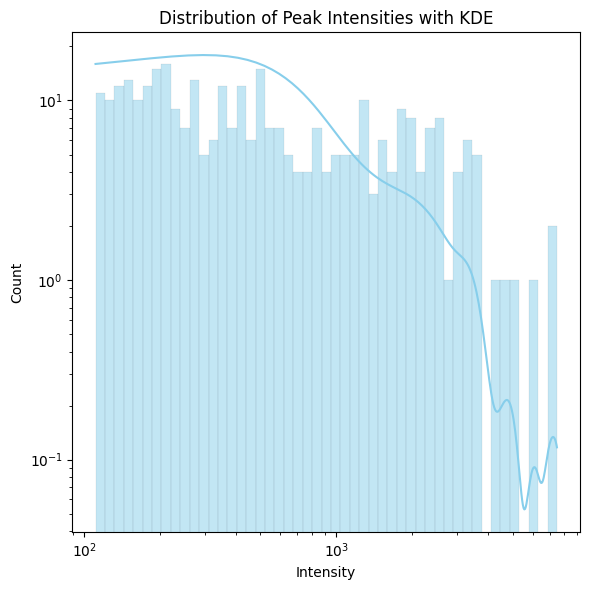

In [105]:
#LOG-SPACED BINNING - WITH KDE
min_val, max_val = np.min(peak_heights), np.max(peak_heights)
log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)


plt.figure(figsize=(6, 6))
sns.histplot(peak_heights, bins=log_bins, kde=True, color='skyblue', edgecolor='black')

plt.xscale('log')
plt.yscale('log')

plt.xlabel("Intensity")
plt.ylabel("Count")
plt.title("Distribution of Peak Intensities with KDE")
plt.tight_layout()
#plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

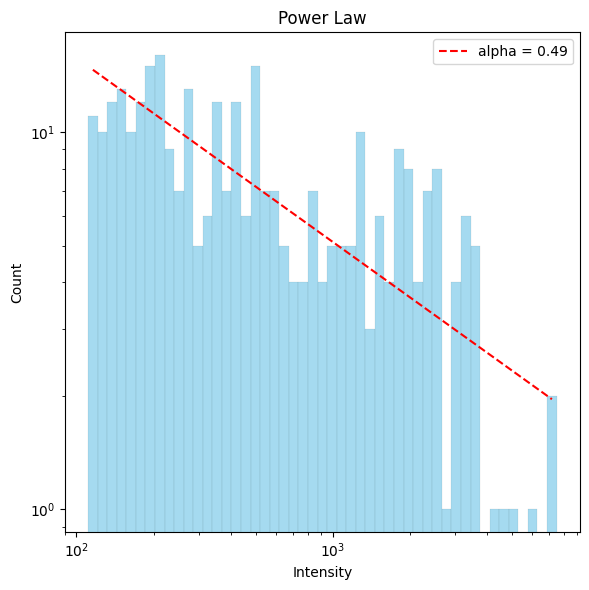

In [106]:
nonzero = counts > 0
log_x = np.log10(bin_centers[nonzero])
log_y = np.log10(counts[nonzero])


slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
alpha = -slope


plt.figure(figsize=(6, 6))
sns.histplot(peak_heights, bins=log_bins, kde=False, color='skyblue', edgecolor='black')
plt.plot(10**log_x, 10**(intercept + slope * log_x), 'r--', label=f'alpha = {alpha:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.title("Power Law")
plt.legend()
plt.tight_layout()
#plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

results = {
    "alpha": alpha,
    "intercept": intercept,
    "r_squared": r_value**2,
    "p_value": p_value,
    "std_err": std_err,
    "slope": slope
}


In [107]:
results["r_squared"]

np.float64(0.5639099574121095)